# Q learning and SARSA for optimal trading

We will present some implementations results based on the idea of the paper [Q-Learning and SARSA: A Comparison between Two Intelligent Stochastic Control Approaches for Financial Trading](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2617630). This article presents how to apply two reinforcement learning methods: 
- online method: Q learning
- offline method: SARSA

They apply these two methods to 5 Italian Stocks: Fiat_FCA.MI, Generali_G.MI, Saipem_SPM.MI, TelecomItalia_TI, Unicredit_UCG.MI. We downloaded the data directly from yahoo finance. But we got different history as summarized below. We put all the code to remove any missing value and do the correct conversion in the Data_loader object (in file data_processor)

In [1]:
from data_processor import Data_loader
folder = 'data\\'
files = ['Generali_G.MI.csv',  
         'Unicredit_UCG.MI.csv',
         'Fiat_FCA.MI.csv',
         'TelecomItalia_TI.csv',
         'Saipem_SPM.MI.csv']

dataframes = {}
for file in files:
    ticker = file[:-4]
    dataframes[ticker] = Data_loader(file, folder).dataFrame
    
for (key,df) in dataframes.items():
    print('{:25s}'.format(key), df['Date'].min().strftime('%d-%b-%Y') )

Generali_G.MI             25-Jul-1986
Unicredit_UCG.MI          03-Jan-2000
Fiat_FCA.MI               03-Jan-2000
TelecomItalia_TI          09-Oct-2003
Saipem_SPM.MI             03-Jan-2000


Let us first graph some stocks

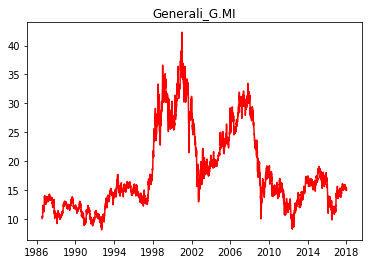

In [2]:
import matplotlib.pyplot as plt
stock = 'Generali_G.MI'
plt.plot( dataframes[stock]['Date'], dataframes[stock]['Close'], 'r-')
plt.title(stock)
plt.show()

We created two main objects:
- one for the Markov Decision Process in the file [mdp.py](mdp.py)
- one for the reinforcement learning methods in [rl_method.py](rl_method.py)

Because the SARSA and Q-learning are very similar, they share most of the code except the learn function whose code is given below

In [3]:
   def learn(self, t, action_t, reward_t):
        if self.method_type == 'Q-Learning':
            next_action = self.best_action()
        elif self.method_type == 'SARSA':
            if np.random.rand() < self.epsilon:
                next_action = np.random.randint(-1, 2)
            else:
                next_action = self.best_action()
        else:
            raise ValueError('invalid algorithm: supported Q-Learning and SARSA')
        d_k = reward_t + self.gamma * \
            self.__Q(self.next_states, next_action) - \
            self.__Q(self.states, action_t)
        learning_rate = self.alpha
        self.theta += learning_rate * d_k * \
            self.__Gradient_Q(self.states, action_t)

The overall idea is to run a Monte Carlo to simulate various paths

We first import the right libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rl_method as rlm
import plot_utils as pu
from mdp import Mdp

# for reproducibility
np.random.seed(1335)
np.set_printoptions()

We set the data and inputs

In [5]:
#%% get data
ticker='TelecomItalia_TI'
prices = dataframes[ticker]['Close'].values
dates = dataframes[ticker]['Date'].values

#%% inputs
N = 5; L = 22; M = 1; transaction_cost = 0.0019
alpha_linear = 0.05; alpha_grid = 0.05; gamma = 0.95
epsilon = 0.1; squashing_dim = 2; iterations_nb = 50

#%% compute data
r_t = np.log(prices[1:]) - np.log(prices[:-1])
prices = prices[1:]; 
dates = dates[1:]

#compute T_max
T_max = r_t.shape[0]
#filter to TMax
r_t = r_t[:T_max]
prices = prices[:T_max]
dates = dates[:T_max]

We choose the method and the trading rules

In [6]:
# choose the method
method_type = 'Q-Learning' 
#method_type = 'SARSA'

trading_rules = [
    'daytrading0',
    'daytrading1',
    'daytrading2',
    'daytrading3',
    'daytrading4',
    'fixed_period',  # index 5
    'hold0',         # index 6
    'hold1',         # index 7
    'hold2']         # index 8
trading_rule = trading_rules[3]  

We create the rl method (either like the paper or the full matrix method)

In [19]:
# type of reinforcement learning method
mean = 0.00; sigma = 0.01
rl1 = rlm.Rl_linear(0, epsilon, r_t, N, M, method_type, alpha_linear, gamma, True)
rl2 = rlm.Rl_full_matrix(0, epsilon, r_t, N, M, method_type, alpha_grid, gamma, False, mean, sigma)
mdp = Mdp(rl1, r_t, L, 0, 0, trading_rule)

We do the loop over the iterations and store the results

In [20]:
# computes return
actions = []
equity_lines = []
start = max(N, L, M); end = T_max - L

for iter in range(iterations_nb):
    state = mdp.reset(start)
    for t in range(start, end):
        # exploration exploitation
        if np.random.rand() < epsilon:
            action_t = np.random.randint(-1, 2)
        else:
            #action_t = mdp.rl_method.next_action()
            action_t = mdp.rl_method.best_action()
        # update
        next_state, reward_t = mdp.step(t, action_t)
        # learn
        mdp.rl_method.learn(t, action_t, reward_t)

    (equity, unused) = mdp.compute_episode_return(None )
    actions.append(mdp.action)
    equity_lines.append(equity)

We compute final values

In [21]:
from plot_helper import plot_3_ts, plot_array
from utils import compute_episode_return

# compute final action
final_action = np.zeros(actions[0].shape[0])
for action_i in actions:
    final_action += action_i
final_action /= iterations_nb

To decide to do an action, we take a threshold of 1/3 as indicated in the paper

In [22]:
threshold = 1 / 3
for i in range(final_action.size):
    if final_action[i] < -threshold:
        final_action[i] = -1
    elif final_action[i] < threshold:
        final_action[i] = 0
    else:
        final_action[i] = 1

We also compute the final capital

In [23]:
# compute final capital
(final_capital, trades_nb) = mdp.compute_episode_return(final_action)

final_equity = []
avg_capital = 0
percent_positive = 0
for equity_i in equity_lines:
    avg_capital += equity_i[-1]
    percent_positive += equity_i[-1] > 1
    final_equity.append(equity_i[-1])
percent_positive /= iterations_nb
avg_capital /= iterations_nb

We plot the result

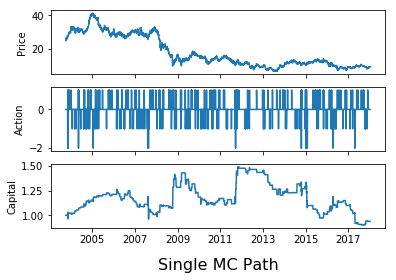

In [24]:
from plot_helper import plot_3_ts, plot_array
plot_result = True
if plot_result:
    max_population = 100
    max_plot = min(mdp.action.shape[0], max_population)
    plot_3_ts(dates, prices, actions[0], equity_lines[0],
              'Time', 'Price', 'Action', 'Capital', 'Single MC Path')
    plt.show()

We can also plot the various capitals

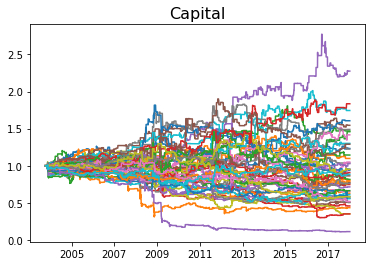

In [25]:
if plot_result:
    plot_array(dates, equity_lines[:max_plot], 'Capital')
    plt.show()

In [ ]:
We can show the equity curves

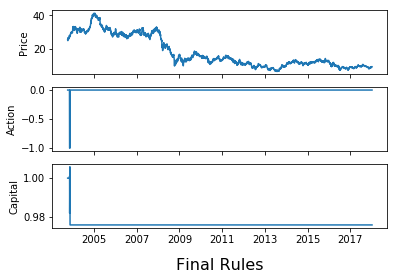

In [26]:
if plot_result:
    # plot_array(dates, actions[:max_plot], 'Actions')
    plot_3_ts(dates, prices, final_action, final_capital,
              'Time', 'Price', 'Action', 'Capital', 'Final Rules')
    plt.show()

We finally display various parameters

In [27]:
# print final value of capital
print('final capital {:.2f}'.format(final_capital[-1]))
print('median capital {:.2f}'.format(avg_capital))
year_frac = pd.Timedelta(dates[-1] - dates[1]).days / 365.25
print('trade per year {:.2f}'.format(trades_nb / year_frac))
avg_return = final_capital[-1] ** (1 / year_frac) - 1
print('avg  return {:.2f}%'.format(avg_return * 100))
long_ret = (prices[-1] / prices[0]) ** (1 / year_frac) - 1
print('long return {:.2f}%'.format(long_ret * 100))
print('% positive = {:.2f}%'.format(percent_positive * 100))

final capital 0.98
median capital 0.93
trade per year 0.07
avg  return -0.17%
long return -6.92%
% positive = 36.00%
